# Previsão de preço de imoveis - Ensemble

In [18]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [19]:
# Carregando dados
df = pd.read_csv('../../datasets/imoveis.csv')

In [20]:
#Pré-processamento
y = df['preco']
X = df.drop(columns=['preco'])

In [21]:
# Variaveis categoricas e numericas
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [22]:
# Pipeline para tratamento
num_pipeline = Pipeline([
  ('inputer', SimpleImputer(strategy='mean'))
])

In [ ]:
cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [24]:
preprocessor = ColumnTransformer([
  ('num', num_pipeline, num_features),
  ('cat', cat_pipeline, cat_features)
])

In [25]:
# Função para avaliação
def avaliar_modelo(modelo, X_treino, X_teste, y_treino, y_teste):
  modelo.fit(X_treino, y_treino)
  y_pred = modelo.predict(X_teste)
  print(modelo.__class__.__name__)
  print("MAE:", mean_absolute_error(y_teste, y_pred))
  print("RMSE:", np.sqrt(mean_squared_error(y_teste, y_pred)))
  print("R2:", r2_score(y_teste, y_pred))
  print("---")
  return y_pred

In [26]:
# Divisão Treino/teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Modelos
modelos = {
  'ArvoreDecisao': DecisionTreeRegressor(random_state=42),
  'RandomForest': RandomForestRegressor(random_state=42),
  'GradientBoosting': GradientBoostingRegressor(n_estimators=100,random_state=42)
}

In [28]:
# Avaliação
resultados = {}
for nome, modelo in modelos.items():
  pipeline = Pipeline([
    ('preprocessamento', preprocessor),
    ('regressor', modelo)
  ])
  y_pred = avaliar_modelo(pipeline,X_treino, X_teste, y_treino,y_teste)
  resultados[nome] = y_pred

Pipeline
MAE: 56450.5959
RMSE: 74254.69941932685
R2: 0.629602757840358
---
Pipeline
MAE: 46221.31989949998
RMSE: 59544.33605400518
R2: 0.7618224795707427
---
Pipeline
MAE: 44781.48260986639
RMSE: 55231.8132063034
R2: 0.7950733420413388
---


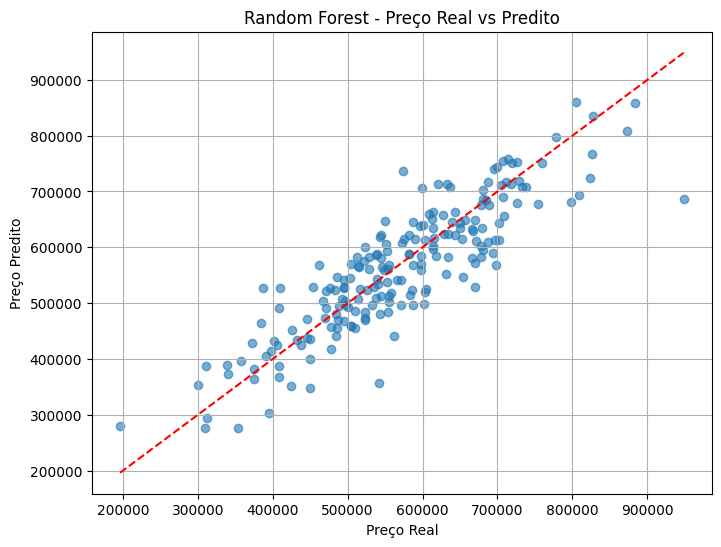

In [29]:
# Grafico de comparação
plt.figure(figsize=(8,6))
plt.scatter(y_teste, resultados['RandomForest'], alpha=0.6)
plt.xlabel('Preço Real')
plt.ylabel('Preço Predito')
plt.title('Random Forest - Preço Real vs Predito')
plt.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], 'r--')
plt.grid(True)
plt.show()

In [30]:
# Feature importance
modelo_rf = modelos['RandomForest']
pipeline_rf = Pipeline([
  ('preprocessamento', preprocessor),
  ('regressor', modelo_rf)
])
pipeline_rf.fit(X,y)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('inputer',
                                                                   SimpleImputer())]),
                                                  ['area', 'quartos',
                                                   'banheiros', 'idade']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['bairro'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [31]:
# Recuperando nomes das features
cat_encoder = pipeline_rf.named_steps['preprocessamento'].transformers_[1][1].named_steps['encoder']
encoded_cat_features = cat_encoder.get_feature_names_out(cat_features)
feature_names = num_features + list(encoded_cat_features)

In [32]:
importancias = pipeline_rf.named_steps['regressor'].feature_importances_

In [33]:
importancia_df = pd.DataFrame({
  'feature':feature_names,
  'importancia':importancias
}).sort_values(by='importancia', ascending=False)

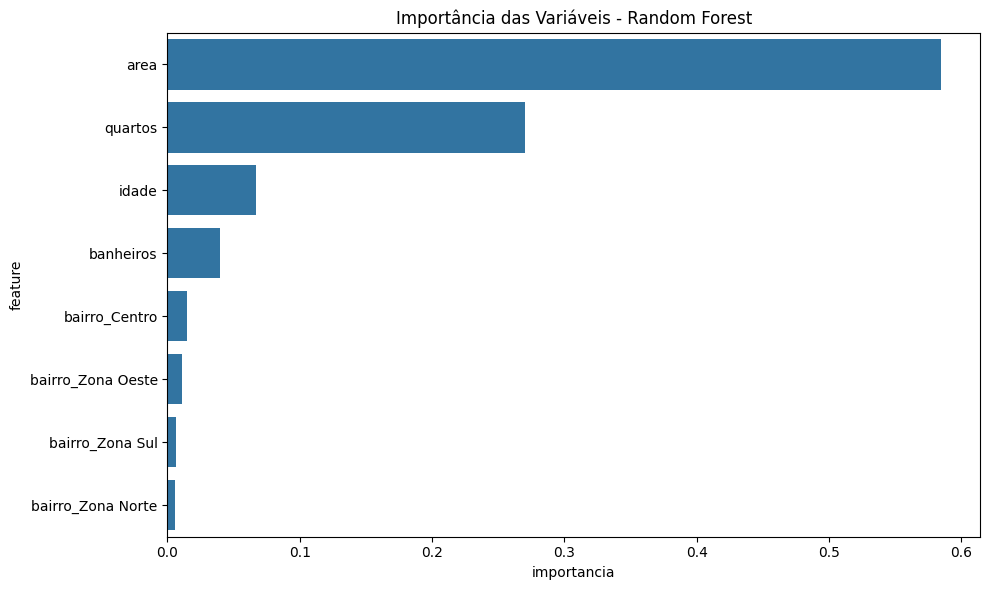

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(data=importancia_df.head(10), x='importancia', y='feature')
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()
plt.show()